# Large Logic Model: Comprehensive Notebook

## Project Overview
This notebook contains the complete implementation of the Large Logic Model, including source code, tests, and example usage.

🧬 INTEGRATED DNF TRANSFORMER COMPARISON EXPERIMENT

📋 Configuration:
  • Training samples: 5000
  • Test samples: 1000
  • Number of variables: 100
  • Target positive ratio: 30.0%
  • Embedding dimensions to test: [4, 8]

📊 Generating datasets...
Generated 9 DNF patterns
  Pattern 1: Variables [36, 64, 85, 92, 96]
  Pattern 2: Variables [28, 48]
  Pattern 3: Variables [51, 68, 72, 78]
  Pattern 4: Variables [6, 40, 94]
  Pattern 5: Variables [37, 79]
Generating dataset: 1500 positive, 3500 negative samples
Actual positive ratio: 0.300
Generating dataset: 300 positive, 700 negative samples
Actual positive ratio: 0.300

📈 Dataset Statistics:
  • Training samples: 5000
  • Test samples: 1000
  • Training positive ratio: 30.0%
  • Test positive ratio: 30.0%

🔬 Training 4D Embedding Model
Model parameters: 365

Training for 50 epochs...
Epoch 0, Loss: 0.7299, Accuracy: 0.4108
Epoch 10, Loss: 0.2359, Accuracy: 0.9248
Epoch 20, Loss: 0.2110, Accuracy: 0.9366
Epoch 30, Loss: 0.2229, Accuracy:

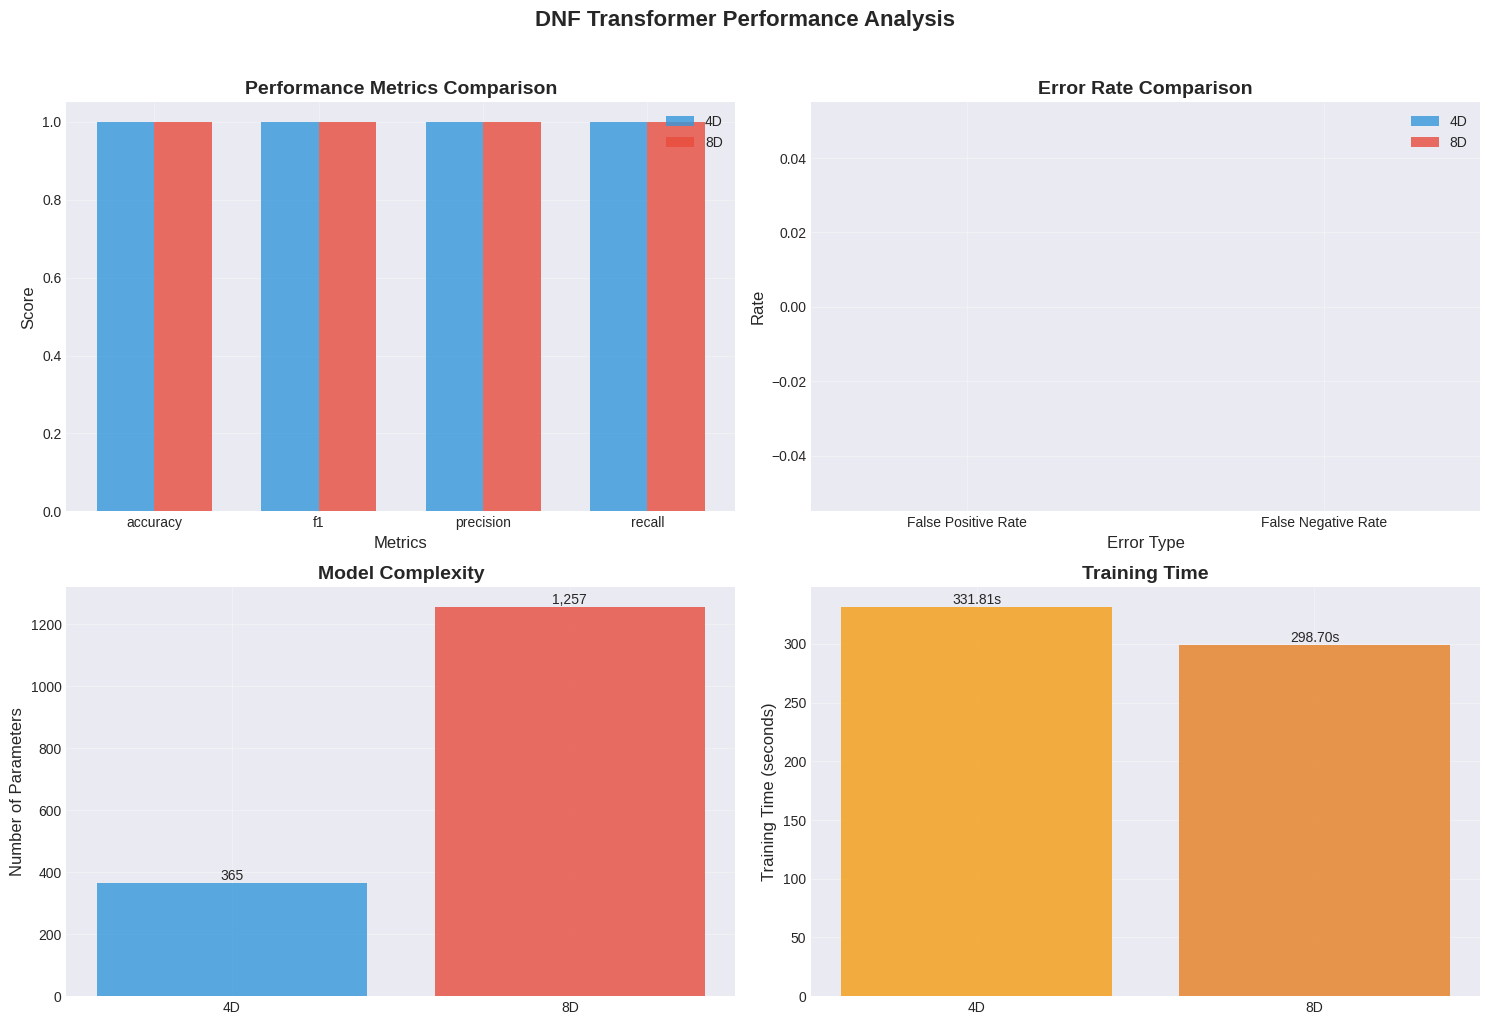

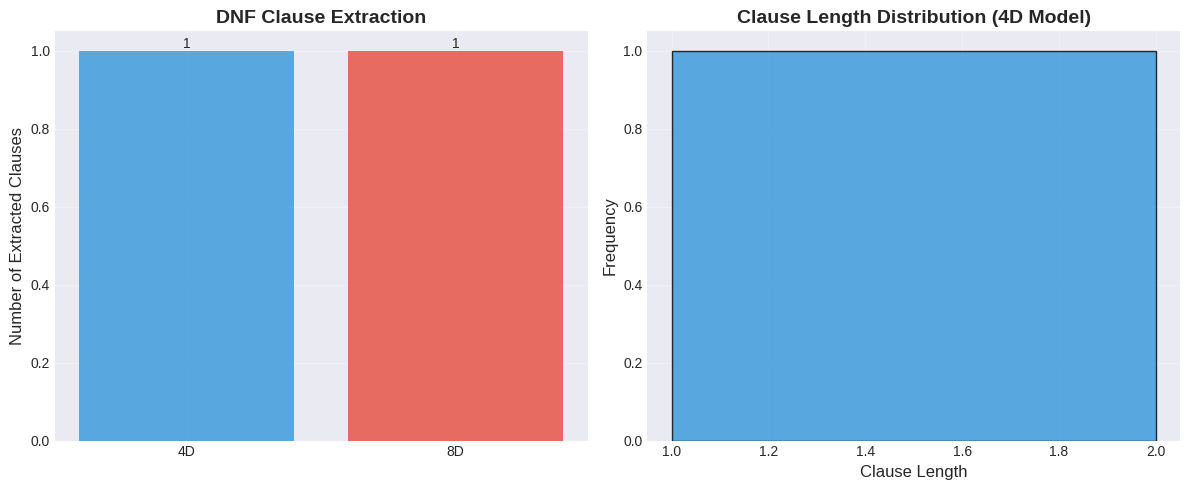


💾 Results saved to 'dnf_transformer_results.json'

📝 SUMMARY REPORT

🏆 Best Model: 4D Embedding

📊 Best Model Performance:
  • Accuracy: 1.000
  • F1 Score: 1.000
  • Precision: 1.000
  • Recall: 1.000

⚙️ Model Characteristics:
  • Parameters: 365
  • Training Time: 331.81s
  • Extracted Clauses: 1

🔍 Confusion Matrix:
  • True Positives: 300
  • True Negatives: 700
  • False Positives: 0
  • False Negatives: 0

✅ INTEGRATED DNF TRANSFORMER TEST COMPLETED!

📁 Output Files:
  • dnf_transformer_results.json - Detailed results
  • dnf_transformer_comparison.png - Performance comparison charts
  • dnf_clause_analysis.png - Clause analysis charts


In [6]:
"""
Integrated DNF Transformer Test Suite - Complete Version
Combines DNF Transformer architecture with comprehensive testing framework
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
import time
import math
from itertools import combinations
import json
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# =============================================================================
# DNF Clause Reducer - Advanced clause reduction functionality
# =============================================================================

class DNFClauseReducer:
    """
    DNF Clause Reducer for extracting and simplifying logical clauses
    from model outputs
    """
    
    def __init__(self, num_variables=100, threshold=0.5):
        """
        Initialize DNF Clause Reducer
        
        Args:
            num_variables (int): Total number of variables
            threshold (float): Probability threshold for clause inclusion
        """
        self.num_variables = num_variables
        self.threshold = threshold
    
    def extract_clauses(self, model_output):
        """
        Extract meaningful clauses from model output
        
        Args:
            model_output (torch.Tensor): Model's output tensor
        
        Returns:
            list: Reduced DNF clauses
        """
        # Convert model output to binary representation
        binary_output = (model_output > self.threshold).float()
        
        # Extract significant variables for each clause
        significant_clauses = self._find_significant_clauses(binary_output)
        
        # Reduce redundancy
        reduced_clauses = self._remove_redundant_clauses(significant_clauses)
        
        return reduced_clauses[:50]  # Limit to top 50 clauses
    
    def _find_significant_clauses(self, binary_output):
        """Find significant clauses based on variable importance"""
        significant_clauses = []
        
        # Compute variable importance
        variable_importance = self._compute_variable_importance(binary_output)
        
        # Sort variables by importance
        sorted_variables = sorted(
            range(len(variable_importance)), 
            key=lambda k: variable_importance[k], 
            reverse=True
        )
        
        # Select top variables to form clauses
        top_k_variables = sorted_variables[:min(20, len(sorted_variables))]
        
        # Generate clauses using top variables
        for clause_length in range(1, min(4, len(top_k_variables) + 1)):
            for clause_vars in combinations(top_k_variables, clause_length):
                clause = list(clause_vars)
                significant_clauses.append(clause)
                if len(significant_clauses) >= 100:  # Limit total clauses
                    return significant_clauses
        
        return significant_clauses
    
    def _compute_variable_importance(self, binary_output):
        """Compute importance of each variable"""
        variable_importance = []
        
        for var in range(min(self.num_variables, binary_output.size(1))):
            # Frequency of variable being 1
            if binary_output.size(0) > 0:
                frequency = torch.mean(binary_output[:, var]).item()
                # Simple importance based on frequency deviation from 0.5
                importance = abs(frequency - 0.5)
            else:
                importance = 0
            variable_importance.append(importance)
        
        return variable_importance
    
    def _remove_redundant_clauses(self, clauses):
        """Remove redundant clauses"""
        # Sort clauses by length (shorter clauses first)
        sorted_clauses = sorted(clauses, key=len)
        
        # Remove redundant clauses
        non_redundant_clauses = []
        for clause in sorted_clauses:
            # Check if current clause is already covered by existing clauses
            is_redundant = any(
                set(clause).issubset(set(existing_clause)) 
                for existing_clause in non_redundant_clauses
            )
            
            # Add clause if not redundant
            if not is_redundant:
                non_redundant_clauses.append(clause)
        
        return non_redundant_clauses
    
    def convert_to_readable_dnf(self, clauses):
        """Convert numeric clauses to readable DNF format"""
        readable_dnf = []
        for clause in clauses:
            # Convert clause to readable format
            readable_clause = [f"x{var}" for var in clause]
            readable_dnf.append(" ∧ ".join(readable_clause))
        
        return readable_dnf

# =============================================================================
# DNF Transformer Encoder - New architecture
# =============================================================================

class PositionalEncoding(nn.Module):
    """Positional encoding for transformer models"""
    
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                           (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(1)].unsqueeze(0)

class DNFTransformerEncoder(nn.Module):
    """
    Transformer-based encoder for DNF pattern recognition
    """
    
    def __init__(self, 
                 num_variables=100, 
                 embedding_dim=8, 
                 num_heads=4, 
                 num_layers=2, 
                 dropout=0.1):
        super().__init__()
        
        self.num_variables = num_variables
        self.embedding_dim = embedding_dim
        
        # Binary embedding layer
        self.embedding = nn.Embedding(2, embedding_dim)
        
        # Positional encoding
        self.positional_encoding = PositionalEncoding(embedding_dim)
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim, 
            nhead=num_heads, 
            dim_feedforward=embedding_dim * 2,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, 
            num_layers=num_layers
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embedding_dim // 2, 1)
        )
    
    def forward(self, x):
        # Convert to binary indices for embedding
        binary_indices = (x > 0.5).long()
        
        # Embed the binary indices
        embedded = self.embedding(binary_indices)
        
        # Add positional encoding
        embedded = self.positional_encoding(embedded)
        
        # Pass through transformer encoder
        encoded = self.transformer_encoder(embedded)
        
        # Global average pooling
        pooled = encoded.mean(dim=1)
        
        # Classification
        output = self.classifier(pooled)
        
        return output

# =============================================================================
# Enhanced Random DNF Pattern Generator
# =============================================================================

class EnhancedRandomDNFPatternGenerator:
    """Enhanced DNF pattern generator with strict true case control"""
    
    def __init__(self, num_variables=100, target_positive_ratio=0.23):
        self.num_variables = num_variables
        self.target_positive_ratio = target_positive_ratio
        
        # Generate random patterns with varying complexity
        self.patterns = self._generate_random_patterns()
        
        print(f"Generated {len(self.patterns)} DNF patterns")
        for i, pattern in enumerate(self.patterns[:5]):  # Show first 5
            print(f"  Pattern {i+1}: Variables {pattern}")
    
    def _generate_random_patterns(self):
        """Generate random DNF patterns with controlled complexity"""
        patterns = []
        
        # Generate patterns of different lengths
        for clause_length in [2, 3, 4, 5]:
            num_patterns_for_length = max(1, 8 // clause_length)
            
            for _ in range(num_patterns_for_length):
                # Randomly select variables for this pattern
                pattern = np.random.choice(
                    self.num_variables, 
                    size=clause_length, 
                    replace=False
                ).tolist()
                patterns.append(sorted(pattern))
        
        # Remove duplicates
        patterns = [list(x) for x in set(tuple(x) for x in patterns)]
        
        return patterns[:15]  # Limit to 15 patterns
    
    def generate_dataset(self, n_samples=1000):
        """Generate dataset with strict positive ratio control"""
        target_positive_count = int(n_samples * self.target_positive_ratio)
        target_negative_count = n_samples - target_positive_count
        
        samples = []
        labels = []
        
        print(f"Generating dataset: {target_positive_count} positive, "
              f"{target_negative_count} negative samples")
        
        # Generate positive samples
        positive_count = 0
        attempts = 0
        max_attempts = target_positive_count * 10
        
        while positive_count < target_positive_count and attempts < max_attempts:
            attempts += 1
            sample = np.zeros(self.num_variables, dtype=int)
            
            # Choose random pattern
            pattern = np.random.choice(len(self.patterns))
            
            # Set pattern positions to 1
            for pos in self.patterns[pattern]:
                sample[pos] = 1
            
            # Add controlled random noise (very limited)
            if np.random.random() < 0.3:  # 30% chance of noise
                noise_positions = np.random.choice(
                    self.num_variables, 
                    size=np.random.randint(1, 3), 
                    replace=False
                )
                for pos in noise_positions:
                    if pos not in self.patterns[pattern]:
                        sample[pos] = np.random.randint(0, 2)
            
            samples.append(sample)
            labels.append(1)
            positive_count += 1
        
        # Generate negative samples
        negative_count = 0
        attempts = 0
        max_attempts = target_negative_count * 10
        
        while negative_count < target_negative_count and attempts < max_attempts:
            attempts += 1
            sample = np.random.randint(0, 2, self.num_variables)
            
            # Ensure it doesn't match any pattern
            matches_pattern = False
            for pattern in self.patterns:
                if all(sample[pos] == 1 for pos in pattern):
                    matches_pattern = True
                    break
            
            if not matches_pattern:
                samples.append(sample)
                labels.append(0)
                negative_count += 1
        
        # Pad with additional negative samples if needed
        while len(samples) < n_samples:
            sample = np.random.randint(0, 2, self.num_variables)
            samples.append(sample)
            labels.append(0)
        
        samples_array = np.array(samples[:n_samples])
        labels_array = np.array(labels[:n_samples])
        
        # Verify ratio
        actual_positive_ratio = np.mean(labels_array)
        print(f"Actual positive ratio: {actual_positive_ratio:.3f}")
        
        return samples_array, labels_array

# =============================================================================
# Training and Evaluation Functions
# =============================================================================

class DNFDataset(Dataset):
    """PyTorch Dataset for DNF data"""
    
    def __init__(self, data, labels):
        self.data = torch.FloatTensor(data)
        self.labels = torch.FloatTensor(labels)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def train_model(model, train_data, train_labels, epochs=20, lr=0.001, verbose=True):
    """
    Train the DNF model with enhanced loss function
    
    Args:
        model: DNF model to train
        train_data: Training data
        train_labels: Training labels
        epochs: Number of training epochs
        lr: Learning rate
        verbose: Whether to print training progress
    
    Returns:
        Trained model
    """
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.BCEWithLogitsLoss()
    
    dataset = DNFDataset(train_data, train_labels)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    model.train()
    training_history = []
    
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        
        for batch_data, batch_labels in dataloader:
            optimizer.zero_grad()
            
            logits = model(batch_data)
            loss = criterion(logits.squeeze(), batch_labels)
            
            # Add sparsity regularization
            sparsity_loss = 0.01 * torch.mean(torch.abs(logits))
            total_loss_batch = loss + sparsity_loss
            
            total_loss_batch.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += total_loss_batch.item()
            
            # Calculate accuracy
            predictions = (torch.sigmoid(logits.squeeze()) > 0.5).float()
            correct += (predictions == batch_labels).sum().item()
            total += batch_labels.size(0)
        
        avg_loss = total_loss / len(dataloader)
        accuracy = correct / total
        training_history.append({'epoch': epoch, 'loss': avg_loss, 'accuracy': accuracy})
        
        if verbose and epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    
    return model, training_history

def evaluate_model(model, test_data, test_labels):
    """
    Comprehensive model evaluation
    
    Args:
        model: Trained model
        test_data: Test data
        test_labels: Test labels
    
    Returns:
        Dictionary of evaluation metrics
    """
    model.eval()
    with torch.no_grad():
        test_tensor = torch.FloatTensor(test_data)
        logits = model(test_tensor)
        predictions = (torch.sigmoid(logits.squeeze()) > 0.5).float().cpu().numpy()
    
    # Calculate metrics
    accuracy = accuracy_score(test_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        test_labels, predictions, average='binary', zero_division=0
    )
    
    # Confusion matrix
    cm = confusion_matrix(test_labels, predictions)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'false_positive_rate': fpr,
        'false_negative_rate': fnr,
        'confusion_matrix': {'tp': int(tp), 'tn': int(tn), 'fp': int(fp), 'fn': int(fn)}
    }

def evaluate_clause_reduction(model, test_data, clause_reducer):
    """
    Evaluate clause reduction capabilities
    
    Args:
        model: Trained model
        test_data: Test data
        clause_reducer: DNFClauseReducer instance
    
    Returns:
        Dictionary with clause reduction metrics
    """
    model.eval()
    with torch.no_grad():
        test_tensor = torch.FloatTensor(test_data[:100])  # Use subset for efficiency
        model_output = model(test_tensor)
    
    # Extract clauses
    clauses = clause_reducer.extract_clauses(torch.sigmoid(model_output))
    readable_clauses = clause_reducer.convert_to_readable_dnf(clauses)
    
    return {
        'num_clauses': len(clauses),
        'readable_clauses': readable_clauses[:10],  # First 10 for display
        'clause_lengths': [len(clause) for clause in clauses]
    }

# =============================================================================
# Visualization Functions
# =============================================================================

def create_performance_charts(results, embedding_dims, save_plots=True):
    """
    Create performance visualization charts
    
    Args:
        results: Dictionary of results
        embedding_dims: List of embedding dimensions tested
        save_plots: Whether to save plots to files
    """
    # Set style
    plt.style.use('seaborn-v0_8-darkgrid')
    
    # Performance metrics chart
    metrics = ['accuracy', 'f1', 'precision', 'recall']
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Main performance metrics
    x = np.arange(len(metrics))
    width = 0.35
    
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
    
    for i, dim in enumerate(embedding_dims):
        values = [results[f"{dim}D"][metric] for metric in metrics]
        ax1.bar(x + i*width, values, width, label=f'{dim}D', alpha=0.8, color=colors[i])
    
    ax1.set_xlabel('Metrics', fontsize=12)
    ax1.set_ylabel('Score', fontsize=12)
    ax1.set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
    ax1.set_xticks(x + width/2)
    ax1.set_xticklabels(metrics)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1.05])
    
    # Error rates
    error_metrics = ['false_positive_rate', 'false_negative_rate']
    x2 = np.arange(len(error_metrics))
    
    for i, dim in enumerate(embedding_dims):
        values = [results[f"{dim}D"][metric] for metric in error_metrics]
        ax2.bar(x2 + i*width, values, width, label=f'{dim}D', alpha=0.8, color=colors[i])
    
    ax2.set_xlabel('Error Type', fontsize=12)
    ax2.set_ylabel('Rate', fontsize=12)
    ax2.set_title('Error Rate Comparison', fontsize=14, fontweight='bold')
    ax2.set_xticks(x2 + width/2)
    ax2.set_xticklabels(['False Positive Rate', 'False Negative Rate'])
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Model complexity
    dims = [f'{dim}D' for dim in embedding_dims]
    params = [results[dim]['parameters'] for dim in dims]
    times = [results[dim]['training_time'] for dim in dims]
    
    ax3.bar(dims, params, alpha=0.8, color=['#3498db', '#e74c3c'])
    ax3.set_ylabel('Number of Parameters', fontsize=12)
    ax3.set_title('Model Complexity', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (dim, param) in enumerate(zip(dims, params)):
        ax3.text(i, param, f'{param:,}', ha='center', va='bottom')
    
    ax4.bar(dims, times, alpha=0.8, color=['#f39c12', '#e67e22'])
    ax4.set_ylabel('Training Time (seconds)', fontsize=12)
    ax4.set_title('Training Time', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (dim, time_val) in enumerate(zip(dims, times)):
        ax4.text(i, time_val, f'{time_val:.2f}s', ha='center', va='bottom')
    
    plt.suptitle('DNF Transformer Performance Analysis', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    if save_plots:
        plt.savefig('dnf_transformer_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Clause analysis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Number of clauses
    clause_counts = [results[f'{dim}D']['num_clauses'] for dim in embedding_dims]
    bars = ax1.bar(dims, clause_counts, alpha=0.8, color=['#3498db', '#e74c3c'])
    ax1.set_ylabel('Number of Extracted Clauses', fontsize=12)
    ax1.set_title('DNF Clause Extraction', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, count in zip(bars, clause_counts):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                f'{count}', ha='center', va='bottom')
    
    # Clause length distribution (for best model)
    best_dim = max(embedding_dims, key=lambda d: results[f"{d}D"]['f1'])
    clause_lengths = results[f'{best_dim}D']['clause_lengths']
    
    if clause_lengths:
        ax2.hist(clause_lengths, bins=range(1, max(clause_lengths)+2), alpha=0.8, 
                color='#3498db', edgecolor='black')
        ax2.set_xlabel('Clause Length', fontsize=12)
        ax2.set_ylabel('Frequency', fontsize=12)
        ax2.set_title(f'Clause Length Distribution ({best_dim}D Model)', 
                     fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig('dnf_clause_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# =============================================================================
# Main Comparison Function
# =============================================================================

def run_comprehensive_comparison(n_trains=5000, n_tests=1000, n_variables=100, 
                                positive_ratio=0.3, embedding_dims=None):
    """
    Run comprehensive comparison between different configurations
    
    Args:
        n_trains: Number of training samples
        n_tests: Number of test samples
        n_variables: Number of DNF variables
        positive_ratio: Target ratio of positive samples
        embedding_dims: List of embedding dimensions to test
    
    Returns:
        Dictionary of results
    """
    print("=" * 80)
    print("🧬 INTEGRATED DNF TRANSFORMER COMPARISON EXPERIMENT")
    print("=" * 80)
    
    if embedding_dims is None:
        embedding_dims = [4, 8]
    
    # Configuration summary
    print("\n📋 Configuration:")
    print(f"  • Training samples: {n_trains}")
    print(f"  • Test samples: {n_tests}")
    print(f"  • Number of variables: {n_variables}")
    print(f"  • Target positive ratio: {positive_ratio:.1%}")
    print(f"  • Embedding dimensions to test: {embedding_dims}")
    
    # Generate dataset
    print("\n📊 Generating datasets...")
    pattern_gen = EnhancedRandomDNFPatternGenerator(
        num_variables=n_variables, 
        target_positive_ratio=positive_ratio
    )
    
    train_data, train_labels = pattern_gen.generate_dataset(n_samples=n_trains)
    test_data, test_labels = pattern_gen.generate_dataset(n_samples=n_tests)
    
    print(f"\n📈 Dataset Statistics:")
    print(f"  • Training samples: {len(train_data)}")
    print(f"  • Test samples: {len(test_data)}")
    print(f"  • Training positive ratio: {np.mean(train_labels):.1%}")
    print(f"  • Test positive ratio: {np.mean(test_labels):.1%}")
    
    # Test different embedding dimensions
    results = {}
    
    for dim in embedding_dims:
        print(f"\n{'='*60}")
        print(f"🔬 Training {dim}D Embedding Model")
        print(f"{'='*60}")
        
        # Create model
        model = DNFTransformerEncoder(
            num_variables=n_variables,
            embedding_dim=dim,
            num_heads=min(4, dim),
            num_layers=2,
            dropout=0.1
        )
        
        # Count parameters
        param_count = sum(p.numel() for p in model.parameters())
        print(f"Model parameters: {param_count:,}")
        
        # Train model
        print(f"\nTraining for 50 epochs...")
        start_time = time.time()
        model, history = train_model(model, train_data, train_labels, 
                                    epochs=50, lr=0.001, verbose=True)
        training_time = time.time() - start_time
        
        # Evaluate model
        print(f"\nEvaluating model...")
        metrics = evaluate_model(model, test_data, test_labels)
        metrics['training_time'] = training_time
        metrics['parameters'] = param_count
        metrics['training_history'] = history
        
        # Evaluate clause reduction
        clause_reducer = DNFClauseReducer(num_variables=n_variables)
        clause_metrics = evaluate_clause_reduction(model, test_data, clause_reducer)
        metrics.update(clause_metrics)
        
        results[f"{dim}D"] = metrics
        
        # Print results
        print(f"\n📊 {dim}D Embedding Results:")
        print(f"  • Accuracy: {metrics['accuracy']:.3f}")
        print(f"  • F1 Score: {metrics['f1']:.3f}")
        print(f"  • Precision: {metrics['precision']:.3f}")
        print(f"  • Recall: {metrics['recall']:.3f}")
        print(f"  • False Positive Rate: {metrics['false_positive_rate']:.3f}")
        print(f"  • False Negative Rate: {metrics['false_negative_rate']:.3f}")
        print(f"  • Extracted clauses: {metrics['num_clauses']}")
        print(f"  • Training time: {metrics['training_time']:.2f}s")
    
    # Final comparison and visualization
    print("\n" + "=" * 80)
    print("📈 FINAL COMPARISON RESULTS")
    print("=" * 80)
    
    # Create comparison table
    print("\n📊 Performance Comparison:")
    header = f"{'Metric':<20}"
    for dim in embedding_dims:
        header += f"{dim}D{'':<10}"
    header += "Best"
    print(header)
    print("-" * 60)
    
    metrics_to_compare = ['accuracy', 'f1', 'precision', 'recall']
    for metric in metrics_to_compare:
        values = {dim: results[f"{dim}D"][metric] for dim in embedding_dims}
        best_dim = max(values, key=values.get)
        
        row = f"{metric:<20}"
        for dim in embedding_dims:
            row += f"{values[dim]:<10.3f}"
        row += f"{best_dim}D"
        print(row)
    
    # Additional metrics
    row = f"{'training_time':<20}"
    for dim in embedding_dims:
        row += f"{results[f'{dim}D']['training_time']:<10.2f}"
    print(row)
    
    row = f"{'parameters':<20}"
    for dim in embedding_dims:
        row += f"{results[f'{dim}D']['parameters']:<10}"
    print(row)
    
    row = f"{'num_clauses':<20}"
    for dim in embedding_dims:
        row += f"{results[f'{dim}D']['num_clauses']:<10}"
    print(row)
    
    # Recommendation
    best_overall = max(embedding_dims, key=lambda d: results[f"{d}D"]['f1'])
    print(f"\n🎯 Recommendation:")
    print(f"✅ {best_overall}D embedding is recommended")
    print(f"  Reason: Highest F1 score ({results[f'{best_overall}D']['f1']:.3f})")
    
    # Show sample clauses
    print(f"\n🔍 Sample Extracted DNF Clauses ({best_overall}D model):")
    for i, clause in enumerate(results[f'{best_overall}D']['readable_clauses'][:5]):
        print(f"  Clause {i+1}: {clause}")
    
    # Create visualizations
    create_performance_charts(results, embedding_dims)
    
    return results

# =============================================================================
# Utility Functions
# =============================================================================

def save_results_to_json(results, filename='dnf_transformer_results.json'):
    """
    Save results to JSON file
    
    Args:
        results: Results dictionary
        filename: Output filename
    """
    # Convert numpy types to native Python types for JSON serialization
    json_results = {}
    for key, value in results.items():
        json_results[key] = {}
        for subkey, subvalue in value.items():
            if subkey == 'training_history':
                # Skip training history for JSON (too verbose)
                continue
            elif isinstance(subvalue, (np.integer, np.floating)):
                json_results[key][subkey] = float(subvalue)
            elif isinstance(subvalue, np.ndarray):
                json_results[key][subkey] = subvalue.tolist()
            elif isinstance(subvalue, list):
                json_results[key][subkey] = subvalue
            elif isinstance(subvalue, dict):
                json_results[key][subkey] = {
                    k: float(v) if isinstance(v, (np.integer, np.floating)) else v 
                    for k, v in subvalue.items()
                }
            else:
                json_results[key][subkey] = subvalue
    
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(json_results, f, ensure_ascii=False, indent=2)
    
    print(f"\n💾 Results saved to '{filename}'")

def print_summary_report(results):
    """
    Print a summary report of the results
    
    Args:
        results: Results dictionary
    """
    print("\n" + "=" * 80)
    print("📝 SUMMARY REPORT")
    print("=" * 80)
    
    # Find best model
    dims = [int(key.replace('D', '')) for key in results.keys()]
    best_dim = max(dims, key=lambda d: results[f"{d}D"]['f1'])
    
    print(f"\n🏆 Best Model: {best_dim}D Embedding")
    print(f"\n📊 Best Model Performance:")
    best_results = results[f"{best_dim}D"]
    print(f"  • Accuracy: {best_results['accuracy']:.3f}")
    print(f"  • F1 Score: {best_results['f1']:.3f}")
    print(f"  • Precision: {best_results['precision']:.3f}")
    print(f"  • Recall: {best_results['recall']:.3f}")
    
    print(f"\n⚙️ Model Characteristics:")
    print(f"  • Parameters: {best_results['parameters']:,}")
    print(f"  • Training Time: {best_results['training_time']:.2f}s")
    print(f"  • Extracted Clauses: {best_results['num_clauses']}")
    
    print(f"\n🔍 Confusion Matrix:")
    cm = best_results['confusion_matrix']
    print(f"  • True Positives: {cm['tp']}")
    print(f"  • True Negatives: {cm['tn']}")
    print(f"  • False Positives: {cm['fp']}")
    print(f"  • False Negatives: {cm['fn']}")

# =============================================================================
# Main Execution
# =============================================================================

if __name__ == "__main__":
    # Run the comprehensive comparison
    results = run_comprehensive_comparison(
        n_trains=5000,
        n_tests=1000,
        n_variables=100,
        positive_ratio=0.3,
        embedding_dims=[4, 8]
    )
    
    # Save results
    save_results_to_json(results)
    
    # Print summary report
    print_summary_report(results)
    
    print("\n" + "=" * 80)
    print("✅ INTEGRATED DNF TRANSFORMER TEST COMPLETED!")
    print("=" * 80)
    print("\n📁 Output Files:")
    print("  • dnf_transformer_results.json - Detailed results")
    print("  • dnf_transformer_comparison.png - Performance comparison charts")
    print("  • dnf_clause_analysis.png - Clause analysis charts")
